In [4]:
!pip install tensorflow==2.10 tensorflow-gpu==2.10 pandas scikit-learn seaborn

You should consider upgrading via the 'E:\TFlow\venv_tf_gpu\Scripts\python.exe -m pip install --upgrade pip' command.


In [5]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Load data

In [7]:
df = pd.read_csv(os.path.join('data','Language Detection.csv'))

In [8]:
df.head()

,Text,Language
0,"Nature, in the broadest sense, is the natural...",English
1,"""Nature"" can refer to the phenomena of the phy...",English
2,"The study of nature is a large, if not the onl...",English
3,"Although humans are part of nature, human acti...",English
4,[1] The word nature is borrowed from the Old F...,English


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6176\1161160102.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Language', data=df, palette='tab10', legend=False)


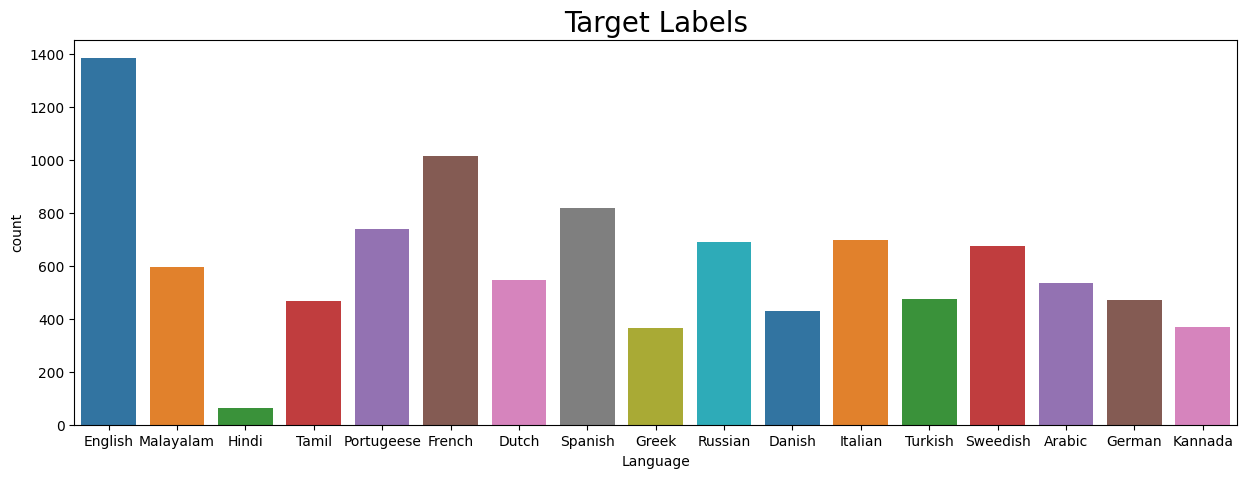

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,5)) 
sns.countplot(x='Language', data=df, palette='tab10', legend=False)
plt.title('Target Labels', fontsize=20)
plt.show()

In [10]:
texts = df['Text'].values
language_labels = df['Language'].values

In [11]:
print(texts.shape[0])
unique_labels = np.unique(language_labels)
print(unique_labels)
print(len(np.unique(language_labels)))

10337
['Arabic' 'Danish' 'Dutch' 'English' 'French' 'German' 'Greek' 'Hindi'
 'Italian' 'Kannada' 'Malayalam' 'Portugeese' 'Russian' 'Spanish'
 'Sweedish' 'Tamil' 'Turkish']
17


In [12]:
label_mapping = {label: i for i, label in enumerate(unique_labels)}
language_number_labels = np.array([label_mapping[label] for label in language_labels])
language_number_labels

array([3, 3, 3, ..., 9, 9, 9])

# Preprocess

In [13]:
from tensorflow.keras.layers import TextVectorization

In [14]:
max_words = 100000
vectorizer = TextVectorization(max_tokens=max_words, output_sequence_length=1000, output_mode='int')

In [15]:
vectorizer.adapt(texts)

In [16]:
vectorized_texts = vectorizer(texts)
vectorized_texts

<tf.Tensor: shape=(10337, 1000), dtype=int64, numpy=
array([[   83,     8,     4, ...,     0,     0,     0],
       [   83,   148,  9435, ...,     0,     0,     0],
       [    4,   761,     9, ...,     0,     0,     0],
       ...,
       [ 1437, 21133,  1644, ...,     0,     0,     0],
       [ 1078,  1644,  3388, ...,     0,     0,     0],
       [ 3395,    88,  1077, ...,     0,     0,     0]], dtype=int64)>

In [17]:
data = tf.data.Dataset.from_tensor_slices((vectorized_texts, language_number_labels))
data = data.shuffle(buffer_size=len(vectorized_texts), seed=42)
data = data.batch(32)

In [18]:
data.as_numpy_iterator().next()

(array([[2609, 3495,  453, ...,    0,    0,    0],
        [ 197,  112,  120, ...,    0,    0,    0],
        [ 104,  802,    6, ...,    0,    0,    0],
        ...,
        [6476,  223, 3071, ...,    0,    0,    0],
        [  10,  142,  483, ...,    0,    0,    0],
        [ 937,   66,   12, ...,    0,    0,    0]], dtype=int64),
 array([12, 11,  8,  3,  8,  2,  6, 10,  1,  3, 12, 10,  9, 14, 16, 14,  3,
        11, 10,  1,  4, 14, 14,  4,  8,  1,  0,  2, 12,  6, 14, 14]))

In [19]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

train_data = data.take(train_size)
val_data = data.skip(train_size).take(val_size)
test_data = data.skip(train_size + val_size).take(test_size)

# RNN Model

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [21]:
rnn_model = Sequential([
    Embedding(input_dim=max_words, output_dim=32, input_length=1000),
    Bidirectional(LSTM(32, activation='tanh')),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(17, activation='softmax')
])

In [22]:
rnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [23]:
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 32)          3200000   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 17)                2193      
                                                        

In [24]:
history = rnn_model.fit(train_data, epochs=5, validation_data=val_data, verbose=1)

Epoch 1/5
226/226 [==============================] - 39s 144ms/step - loss: 1.9238 - accuracy: 0.3479 - val_loss: 0.9499 - val_accuracy: 0.6602
Epoch 2/5
226/226 [==============================] - 38s 169ms/step - loss: 0.8188 - accuracy: 0.7080 - val_loss: 0.5240 - val_accuracy: 0.8184
Epoch 3/5
226/226 [==============================] - 33s 147ms/step - loss: 0.4368 - accuracy: 0.8630 - val_loss: 0.2788 - val_accuracy: 0.9072
Epoch 4/5
226/226 [==============================] - 45s 200ms/step - loss: 0.2053 - accuracy: 0.9325 - val_loss: 0.0934 - val_accuracy: 0.9688
Epoch 5/5
226/226 [==============================] - 40s 177ms/step - loss: 0.1035 - accuracy: 0.9657 - val_loss: 0.0821 - val_accuracy: 0.9717


Text(0.5, 1.0, 'Training and validation loss')

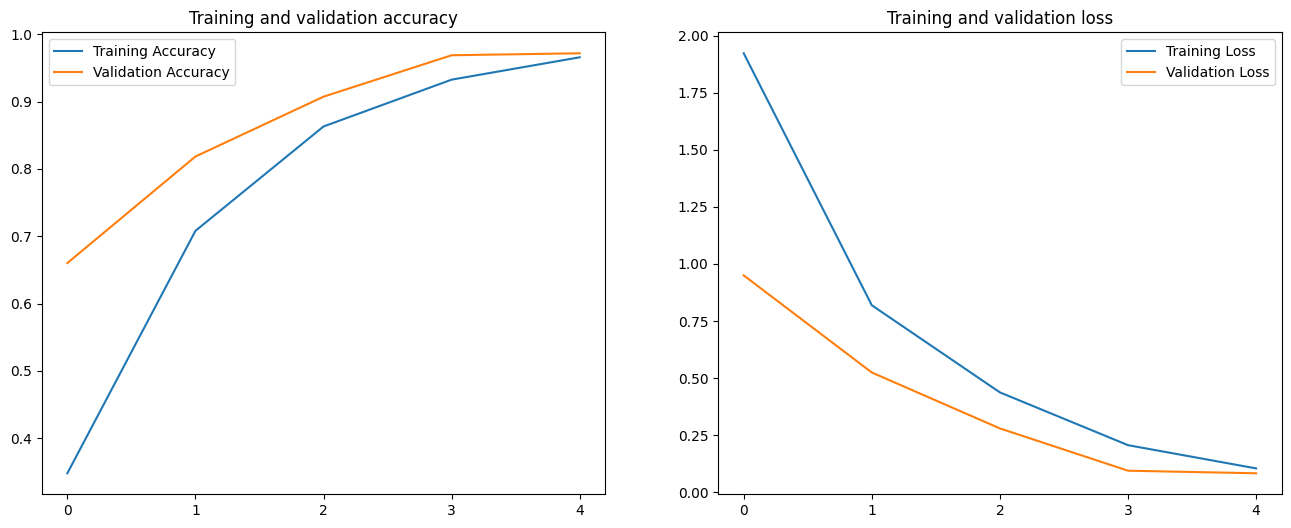

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = len(acc)

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xticks(range(0, epochs, 1))
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xticks(range(0, epochs, 1))
plt.legend()
plt.title('Training and validation loss')

# Evaluate

In [26]:
rnn_model.evaluate(test_data)

32/32 [==============================] - 2s 66ms/step - loss: 0.0806 - accuracy: 0.9746


[0.08055578172206879, 0.974609375]

# Test

In [30]:
text = "En un hermoso día soleado, decidí salir a caminar por el parque cercano a mi casa, disfrutando de la brisa fresca y escuchando el canto de los pájaros en los árboles."
# Spanish
vecto_text = vectorizer(text)

In [31]:
test_predict= np.argmax(rnn_model.predict(np.expand_dims(vecto_text, 0)))
print(f"Language of '{text}': {unique_labels[test_predict]}")

1/1 [==============================] - 0s 95ms/step
Language of 'En un hermoso día soleado, decidí salir a caminar por el parque cercano a mi casa, disfrutando de la brisa fresca y escuchando el canto de los pájaros en los árboles.': Spanish


In [32]:
from tensorflow.keras.models import load_model

rnn_model.save('language_recognition.keras')